# Voice Change

[この記事](https://qiita.com/KSRG_Miyabi/items/2a3b5bdca464ec1154d7)を参考に，実装してみた．

DiscoGAN（Learning to Discover Cross-Domain Relations　with Generative Adversarial Networks）の論文は[ここ](https://arxiv.org/pdf/1703.05192.pdf)．

タスク
* Batch_normalization
* FFTとDCTのどっちが良い？
* 画像の淵にノイズがたまってしまうのを解消

## import

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import cv2
import os
import random
import subprocess

import tensorflow as tf
import tflearn
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, upsample_2d
from tflearn.layers.merge_ops import merge

%matplotlib inline

/home/takiguchi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Manager Class

In [2]:
class DataManager():
    
    def __init__(self):
        self.N = 256
        self.dif = 128
        self.window = np.hamming(self.N)
        self.im_width = 128     
        
    def voice2images(self, data, folder_name):
        i = 0
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        while(True):
            _data = data[i*_dif:i*_dif + _wav]
            if (len(_data) < _wav):
                break
            self.save_image(self.spec2image(_data), folder_name + "/" + str(i) + ".png")
            i = i + 1
    
    def images2voice(self, folder_name):
        directory = os.listdir(folder_name)
        num_images = len(directory)
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        voice = np.zeros(_dif * (num_images+1))
        for i in range(num_images):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            if data is None:
                break
            voice[i*_dif:i*_dif+_wav] = voice[i*_dif:i*_dif+_wav] + self.image2spec(data)*np.r_[np.linspace(0,1,_dif), np.linspace(1,0,_dif)]
        
        """
        voice = []
        for i in range(image_num):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            voice.append(self.image2spec(data))
        """
        return voice
        
    def spec2image(self, data):
        image = []
        for i in range(self.im_width):
            image.append(self.dct(data[self.dif*i:self.dif*i + self.N]))
        return image
    
    def image2spec(self, data):
        voice = np.zeros(self.N + self.dif*(self.im_width-1))        
        vsum = np.zeros(self.N + self.dif*(self.im_width-1))
        for i in range(self.im_width):
            voice[self.dif*i:self.dif*i + self.N] = voice[self.dif*i:self.dif*i + self.N] + self.idct(data[i]) * self.window
            vsum[self.dif*i:self.dif*i + self.N] +=self.window ** 2 
        pos = (vsum != 0)
        voice[pos] /= vsum[pos]
        return voice
        
    def dct(self, data):       
        data = data * self.window
        # data = scipy.fftpack.fft(data)
        data = scipy.fftpack.dct(data)
        pm = np.sign(data)
        # data = np.log(np.abs(data)+0.0001)
        data = np.abs(data) ** 0.2
        data = pm * data
        data = data[:int(self.N/2)]
        data = data / 15
        data = (data + 1) / 2
        return data
    
    def idct(self, data):
        data = data * 2 - 1
        data = data * 15
        pm = np.sign(data)
        data = np.abs(data) ** 5
        data = pm * data
        data = np.append(data, np.zeros(int(self.N/2)))
        data = scipy.fftpack.idct(data) / (2 * len(data))
        # data = scipy.fftpack.ifft(data)
        return data

    def FGLA(self, data, length, dif, side, window):
        
        data = np.array(data)
        X = data[:]
        alpha = 0.99
        
        for i in range(len(data)):
            s = np.random.randn(np.shape(data[i]))*3.1415926
            X[i] = data[i] * np.cos(s)
        for _ in range(10):
            L = X
            x = self.image2spec(X)
            X = self.spec2image(x)
            X = data * X / np.abs(X)
            X = X + alpha*(X - L)
        result = self.image2spec(X)
        return result

    def read_wave(self, filename):
        wf = wave.open(filename , "r" )
        buf = wf.readframes(wf.getnframes())
        data = np.frombuffer(buf, dtype="int16") # 16 kHz?
        return data    
    
    def save_wave(self, data, filename):
        wf = wave.open(filename, "w")
        wf.setnchannels(2)
        wf.setsampwidth(2) #2 byte = 16 bit
        wf.setframerate(16000)
        wf.writeframes(np.array(data,  dtype="int16"))
        wf.close()
        
    def save_image(self, data, file_name):
        data = np.array(data) * 255
        cv2.imwrite(file_name, data)
        
    def read_image(self, file_name):
        data = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        return data / 255
    
    def next_batch(self, num, folder_name):
        images = []
        directory = os.listdir(folder_name)
        num_images = len(directory)
        for i in range(num):
            image_num = random.randrange(0, num_images)
            image = self.read_image(folder_name + "/" + str(image_num) + ".png")
            images.append(image)
        return images

## Data init

In [3]:
dm = DataManager()

In [4]:
"""
voice1 = dm.read_wave("VoiceData/kamiya.wav")
voice2 = dm.read_wave("VoiceData/kizuna.wav")

dm.voice2images(voice1, "ImageData/Kamiya_images")
dm.voice2images(voice2, "ImageData/Kizuna_images")
"""

'\nvoice1 = dm.read_wave("VoiceData/kamiya.wav")\nvoice2 = dm.read_wave("VoiceData/kizuna.wav")\n\ndm.voice2images(voice1, "ImageData/Kamiya_images")\ndm.voice2images(voice2, "ImageData/Kizuna_images")\n'

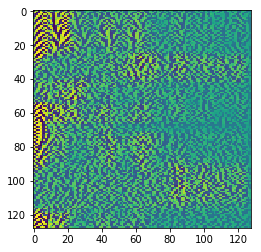

In [5]:
plt.imshow(dm.read_image("ImageData/Kamiya_images/30.png"))

In [6]:
"""
# Sample wav
voice = dm.images2voice("ImageData/Kamiya_images")
dm.save_wave(voice, "test.wav")
"""

'\n# Sample wav\nvoice = dm.images2voice("ImageData/Kamiya_images")\ndm.save_wave(voice, "test.wav")\n'

## Network

In [7]:
class DiscoGAN():
    
    def __init__(self, sess):
        
        self.sess = sess
                    
        self.x_1 = tflearn.input_data(shape=[None, 128, 128, 1])
        self.x_2 = tflearn.input_data(shape=[None, 128, 128, 1])
        
        self.gen_learning_rate = 1e-5
        self.dis_learning_rate = 1e-5
        
        self.param_gan = 0.1
        self.param_feat = 0.8
        self.param_recon = 1.0
        self.num_critic = 1
        self.step = 0
        
        self._create_optimizer()
        
        self.marged_summary = tf.summary.merge_all()
        self.summary_writer = tf.summary.FileWriter('./logs', sess.graph)
        
        sess.run(tf.global_variables_initializer())
    
    def create_gen_network(self, network_name, inputs, reuse=None):
        with tf.variable_scope(network_name, reuse=reuse):
            
            """
            conv1_1 = conv_2d(inputs, 32, 3, activation='relu')            
            conv1_2 = conv_2d(conv1_1, 32, 3, activation='relu')
            pool1 = max_pool_2d(conv1_2, 2)
            
            conv2_1 = conv_2d(pool1, 64, 3, activation='relu')            
            conv2_2 = conv_2d(conv2_1, 64, 3, activation='relu')
            pool2 = max_pool_2d(conv2_2, 2)
            
            conv3_1 = conv_2d(pool2, 128, 3, activation='relu')            
            conv3_2 = conv_2d(conv3_1, 128, 3, activation='relu')
            pool3 = max_pool_2d(conv3_2, 2)
            
            conv4_1 = conv_2d(pool3, 256, 3, activation='relu')            
            conv4_2 = conv_2d(conv4_1, 256, 3, activation='relu')
            pool4 = max_pool_2d(conv4_2, 2)

            conv5_1 = conv_2d(pool4, 512, 3, activation='relu')
            conv5_2 = conv_2d(conv5_1, 512, 3, activation='relu')
            
            up6 = conv_2d(upsample_2d(conv5_2, 2), 256, 2)
            merge6 = merge([up6, conv4_2], mode='concat', axis=3)
            conv6_1 = conv_2d(merge6, 256, 3, activation='relu')
            conv6_2 = conv_2d(conv6_1, 256, 3, activation='relu')
            
            up7 = conv_2d(upsample_2d(conv6_2, 2), 128, 2)
            merge7 = merge([up7, conv3_2], mode='concat', axis=3)
            conv7_1 = conv_2d(merge7, 128, 3, activation='relu')
            conv7_2 = conv_2d(conv7_1, 128, 3, activation='relu')
            
            up8 = conv_2d(upsample_2d(conv7_2, 2), 64, 2)
            merge8 = merge([up8, conv2_2], mode='concat', axis=3)
            conv8_1 = conv_2d(merge8, 64, 3, activation='relu')
            conv8_2 = conv_2d(conv8_1, 64, 3, activation='relu')
            
            up9 = conv_2d(upsample_2d(conv8_2, 2), 32, 2)
            merge9 = merge([up9, conv1_2], mode='concat', axis=3)
            conv9_1 = conv_2d(merge9, 32, 3, activation='relu')
            conv9_2 = conv_2d(conv9_1, 32, 3, activation='relu')
            
            conv9_3 = conv_2d(conv9_2, 2, 3, activation='relu')
            
            outputs = conv_2d(conv9_3, 1, 1, activation='tanh')
            """
            
            filter_size = 4
            stride = 1
            
            conv1_1 = conv_2d(inputs, 32, filter_size, stride, activation='relu')            
            conv1_2 = conv_2d(conv1_1, 32, filter_size, stride, activation='relu')
            pool1 = max_pool_2d(conv1_2, 2)
            
            conv2_1 = conv_2d(pool1, 64, filter_size, stride, activation='relu')            
            conv2_2 = conv_2d(conv2_1, 64, filter_size, stride, activation='relu')
            pool2 = max_pool_2d(conv2_2, 2)
            
            conv3_1 = conv_2d(pool2, 128, filter_size, stride, activation='relu')            
            conv3_2 = conv_2d(conv3_1, 128, filter_size, stride, activation='relu')
            pool3 = max_pool_2d(conv3_2, 2)
            
            conv4_1 = conv_2d(pool3, 256, filter_size, stride, activation='relu')            
            conv4_2 = conv_2d(conv4_1, 256, filter_size, stride, activation='relu')
            pool4 = max_pool_2d(conv4_2, 2)

            conv5_1 = conv_2d(pool4, 512, filter_size, stride, activation='relu')
            conv5_2 = conv_2d(conv5_1, 512, filter_size, stride, activation='relu')
            
            up6 = conv_2d(upsample_2d(conv5_2, 2), 256, 2)
            merge6 = merge([up6, conv4_2], mode='concat', axis=3)
            conv6_1 = conv_2d(merge6, 256, filter_size, stride, activation='relu')
            conv6_2 = conv_2d(conv6_1, 256, filter_size, stride, activation='relu')
            
            up7 = conv_2d(upsample_2d(conv6_2, 2), 128, 2)
            merge7 = merge([up7, conv3_2], mode='concat', axis=3)
            conv7_1 = conv_2d(merge7, 128, filter_size, stride, activation='relu')
            conv7_2 = conv_2d(conv7_1, 128, filter_size, stride, activation='relu')
            
            up8 = conv_2d(upsample_2d(conv7_2, 2), 64, 2)
            merge8 = merge([up8, conv2_2], mode='concat', axis=3)
            conv8_1 = conv_2d(merge8, 64, filter_size, stride, activation='relu')
            conv8_2 = conv_2d(conv8_1, 64, filter_size, stride, activation='relu')
            
            up9 = conv_2d(upsample_2d(conv8_2, 2), 32, 2)
            merge9 = merge([up9, conv1_2], mode='concat', axis=3)
            conv9_1 = conv_2d(merge9, 32, filter_size, stride, activation='relu')
            conv9_2 = conv_2d(conv9_1, 32, filter_size, stride, activation='relu')
            
            outputs = conv_2d(conv9_2, 1, 1, activation='sigmoid')
            
        return outputs
        
    def create_dis_network(self, network_name, inputs, reuse=None):
        with tf.variable_scope(network_name, reuse=reuse):
            
            network = conv_2d(inputs, 64, 1,  activation='leaky_relu')
            network = conv_2d(network, 128, 1, activation='leaky_relu')
            network = conv_2d(network, 256, 1, activation='leaky_relu')
            network = conv_2d(network, 512, 1, activation='leaky_relu')
            #network = fully_connected(network, 256, activation='relu')
            outputs = fully_connected(network, 1)
            
        return outputs, network
    
    def compute_loss_gan(self, y_real, y_fake):
        
        loss_dis = -(tf.reduce_mean(y_real) - tf.reduce_mean(y_fake))
        loss_gen = -tf.reduce_mean(y_fake)
        """
        batch_size = y_real.shape[0]
        loss_dis = tf.sum(F.softplus(-y_real) + F.softplus(y_fake)) / batch_size
        loss_gen = tf.sum(F.softplus(-y_fake))
        
        loss_dis =  -tf.reduce_mean(tf.log(y_real) + tf.log(1. - y_fake))
        loss_gen = -tf.reduce_mean(tf.log(y_fake))
        
        y_real = tf.clip_by_value(y_real, 1e-10, 1.0)
        y_fake = tf.clip_by_value(y_fake, 1e-10, 1.0)

        loss_dis =  -tf.reduce_mean(tf.log(y_real) + tf.log(1. - y_fake))
        loss_gen = -tf.reduce_mean(tf.log(y_fake))
        """
        return loss_dis, loss_gen

    def compute_loss_feat(self, feats_real, feats_fake):
        """
        losses = 0
        for feat_real, feat_fake in zip(feats_real, feats_fake):
        feat_real_mean = tf.reduce_sum(feat_real, 0) / feat_real.shape[0]
        feat_fake_mean = tf.reduce_sum(feat_fake, 0) / feat_fake.shape[0]
        l2 = (feat_real_mean - feat_fake_mean) ** 2
        loss = tf.reduce_sum(l2) / l2.size
        losses += loss
        return losses
        """
        return tflearn.mean_square(feats_real, feats_fake)
        
    
    def _create_optimizer(self):

        self.x_12 = self.create_gen_network("G1", self.x_1)
        self.x_21 = self.create_gen_network("G2", self.x_2)

        self.x_121 = self.create_gen_network("G2", self.x_12, reuse=True)
        self.x_212 = self.create_gen_network("G1", self.x_21, reuse=True)

        recon_loss_1 = tflearn.mean_square(self.x_1, self.x_121)
        recon_loss_2 = tflearn.mean_square(self.x_2, self.x_212)

        y_1_real, feats_1_real = self.create_dis_network("D1", self.x_1)
        y_1_fake, feats_1_fake = self.create_dis_network("D1", self.x_21, reuse=True)

        y_2_real, feats_2_real = self.create_dis_network("D2", self.x_2)
        y_2_fake, feats_2_fake = self.create_dis_network("D2", self.x_12, reuse=True)

        feat_loss_1 = self.compute_loss_feat(feats_1_real, feats_1_fake)
        feat_loss_2 = self.compute_loss_feat(feats_2_real, feats_2_fake)
        
        gan_loss_dis_1, gan_loss_gen_1 = self.compute_loss_gan(y_1_real, y_1_fake)
        gan_loss_dis_2, gan_loss_gen_2 = self.compute_loss_gan(y_2_real, y_2_fake)
        
        # gan = 0.1
        # feat = 0.9
        # recon = 1

        total_loss_gen_1 = self.param_gan*gan_loss_gen_2 + self.param_feat*feat_loss_2 + self.param_recon*recon_loss_1
        total_loss_gen_2 = self.param_gan*gan_loss_gen_1 + self.param_feat*feat_loss_1 + self.param_recon*recon_loss_2
        
        self.gen_loss = total_loss_gen_1 + total_loss_gen_2
        self.dis_loss = gan_loss_dis_1 + gan_loss_dis_2
        
        self.clip_op = [self.clip_weights("D1"), self.clip_weights("D2")]
        
        self.optimize_gen_op = tf.train.RMSPropOptimizer(self.gen_learning_rate).minimize(
            loss=self.gen_loss
        )
        self.optimize_dis_op = tf.train.RMSPropOptimizer(self.dis_learning_rate).minimize(
            loss=self.dis_loss
        )
        
        tf.summary.scalar("Generator1_loss", gan_loss_gen_1)
        tf.summary.scalar("Generator2_loss", gan_loss_gen_2)
        tf.summary.scalar("Wasserstein1_distance", gan_loss_dis_1)
        tf.summary.scalar("Wasserstein2_distance", gan_loss_dis_2)   
        tf.summary.scalar("Feature1_loss", feat_loss_1)
        tf.summary.scalar("Feature2_loss", feat_loss_2)
        tf.summary.scalar("Reconstruction1_loss", recon_loss_1)
        tf.summary.scalar("Reconstruction2_loss", recon_loss_2)
        tf.summary.scalar("All_Gen_loss",self.gen_loss)        
        tf.summary.scalar("All_Dis_loss",self.dis_loss)
    
    def clip_weights(self, network_name):
        
        lower = -0.01
        upper = 0.01
        return [tf.assign(_, tf.clip_by_value(_, lower, upper)) for _ in tf.trainable_variables() if 'network_name/' in _.name]
        
    def optimize_gen(self, x_1, x_2):
        summary, _ = self.sess.run([self.marged_summary, self.optimize_gen_op], feed_dict={
            self.x_1: x_1,
            self.x_2: x_2
        })
        self.summary_writer.add_summary(summary, self.step)
        self.step += 1
        
    def optimize_dis(self, x_1, x_2):
        summary, _ = self.sess.run([self.marged_summary, self.optimize_dis_op], feed_dict={
            self.x_1: x_1,
            self.x_2: x_2
        }) 
        self.summary_writer.add_summary(summary, self.step)
        self.step += 1
        
    def clip(self):
        self.sess.run(self.clip_op) 
        
    def gen1(self, image):
        return self.sess.run(self.x_12, feed_dict={
            self.x_1: image,
        }) 

    def gen2(self, image):
        return self.sess.run(self.x_21, feed_dict={
            self.x_2: image,
        }) 

## Train & Test

In [ ]:
def train(sess, discoGAN, folder_name1, folder_name2, epoch, batch_size):
        
    for i in range(epoch):
        if ((i+1) % 50 == 0):
            print(str(i+1) + "/" + str(epoch))
        if ((i+1) % 50 == 0):
            test_image = dm.next_batch(1, folder_name1)
            show_image(sess, discoGAN, np.reshape(test_image, (-1, 128, 128, 1)))
            
        for x in range(discoGAN.num_critic):            
            images1 = dm.next_batch(batch_size, folder_name1)
            images2 = dm.next_batch(batch_size, folder_name2)
            images1 = np.reshape(images1, (-1, 128, 128, 1))
            images2 = np.reshape(images2, (-1, 128, 128, 1))

            discoGAN.clip()
            discoGAN.optimize_dis(images1, images2)
        
        images1 = dm.next_batch(batch_size, folder_name1)
        images2 = dm.next_batch(batch_size, folder_name2)
        images1 = np.reshape(images1, (-1, 128, 128, 1))
        images2 = np.reshape(images2, (-1, 128, 128, 1))
        
        discoGAN.clip()
        discoGAN.optimize_gen(images1, images2)
        
    saver = tf.train.Saver()
    saver.save(sess, "ModelData/model.ckpt")
            
def show_image(sess, discoGAN, image):
    
    gen_image = discoGAN.gen1(image)
    
    image = np.reshape(image, (128, 128))
    gen_image = np.reshape(gen_image, (128, 128))

    plt.title("original")
    plt.imshow(image)
    plt.show()
    plt.title("generated")
    plt.imshow(gen_image)
    plt.show()
        
def gen1_images(discoGAN, folder_name1, folder_name2):
    
    directory = os.listdir(folder_name1)
    num_images = len(directory)

    for i in range(num_images):
        image = dm.read_image(folder_name1 + "/" + str(i) + ".png")
        gen_image = discoGAN.gen1(np.reshape(image, (-1, 128, 128, 1)))
        gen_image = np.reshape(gen_image, (128, 128))
        dm.save_image(gen_image, folder_name2 + "/" + str(i) + ".png")

def gen2_images(discoGAN, folder_name1, folder_name2):
        
    directory = os.listdir(folder_name1)
    num_images = len(directory)

    for i in range(num_images):
        image = dm.read_image(folder_name1 + "/" + str(i) + ".png")
        gen_image = discoGAN.gen2(np.reshape(image, (-1, 128, 128, 1)))
        gen_image = np.reshape(gen_image, (128, 128))
        dm.save_image(gen_image, folder_name2 + "/" + str(i) + ".png")
     

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
50/100000


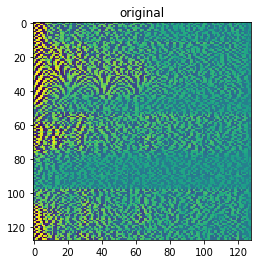

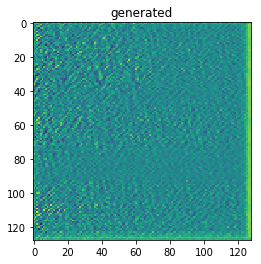

100/100000


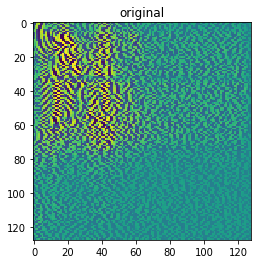

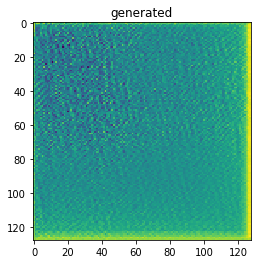

In [ ]:
with tf.Session() as sess:
        
    discoGAN = DiscoGAN(sess)
    sess.run(tf.global_variables_initializer())
    
    train(sess, discoGAN, "ImageData/Kamiya_images", "ImageData/Kizuna_images", epoch=100000, batch_size=4)
    gen1_images(discoGAN, "ImageData/Kamiya_images", "ImageData/Kamiya_to_Kizuna_images")

In [ ]:
voice = dm.images2voice("ImageData/Kamiya_to_Kizuna_images")
dm.save_wave(voice, "Result/gen.wav")   